In [7]:
#!pip install netCDF4

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset

%matplotlib inline

In [9]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [10]:
#nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates
nc_path  = '//home/hanna/Desktop/examples_master_thesis/'
nc_file  = glob.glob(nc_path + '*.nc')[0]
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan
d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
d_theta = lat_array[1:, :] - lat_array[:-1, :]

# Padding the axis -- we removed by taking the difference
pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values
d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

In [11]:
lat_array[0:2][:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [12]:
np.shape(lat_array)

(3712, 3712)

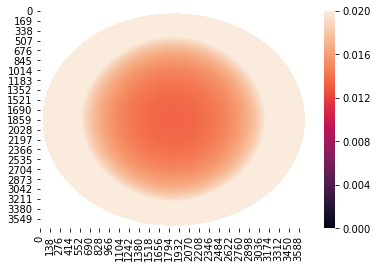

In [13]:
sns.heatmap(d_phi, vmin = 0, vmax = 0.02)

In [14]:
rootgrp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creator_name: EUMETSAT
    creator_url: http://archive.eumetsat.int
    creator_email: archive@eumetsat.int
    institution: EUMETSAT
    license: CopyRight EUMETSAT 2008
    Conventions: CF-1.0
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    summary: NA
    keywords: EUMETSAT, ARCHIVE, NetCDF, CLOUD MASK
    history: EUMETSAT CopyRight 2008
    comment: DRAFT VERSION
    wmo_filename: W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190612113000.nc
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: 0.0
    GRIB_param_Nx: 3712
    GRIB_param_Ny: 3712
    GRIB_orgReferenceTime: 20190612113000
    time_coverage_start: 20190612113000
    time_coverage_end: 20190612113000
    source: /data/products/1338648/MSG4-SEVI-MSGCLMK-0100-0100-20190612113000.000000000Z-20190612114350-1338648.nc.tmp
    dimensions

In [37]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)


In [16]:
def compute_dDegrees(lat, lon):

    d_phi_new2    = np.nan*np.zeros(np.shape(lat))
    d_theta_new2  = np.nan*np.zeros(np.shape(lat))
    cell_areas    = np.nan*np.zeros(np.shape(lat))
    
    count_lon     = 0
    count_lat     = 0
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            left_half_dist     = (lon[i, j] - lon[i, j+1])/2
            right_half_dist    = (lon[i, j-1] - lon[i, j])/2
            
            if lon[i, j] == lon[i, j+1]:
                count_lon += 1
                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon = (np.abs(left_half_dist) + np.abs(right_half_dist))/2
            d_phi_new2[i][j]   = dlon
            
            if lat[i-1, j] == lat[i, j]:
                count_lat += 1
                
            upper_half_dist    = (lat[i+1, j] - lat[i, j])/2
            lower_half_dist    = (lat[i, j] - lat[i-1, j])/2
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat = (np.abs(upper_half_dist) + np.abs(lower_half_dist))/2
            d_theta_new2[i][j] = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat

In [17]:
d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat = compute_dDegrees(lat_array, lon_array)

In [18]:
count_lon, count_lat

(0, 0)

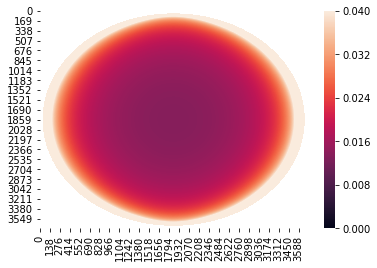

In [19]:
sns.heatmap(d_phi_new2, vmin = 0, vmax = 0.04)

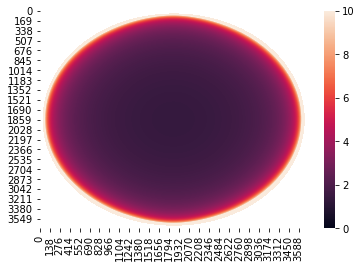

In [20]:
sns.heatmap(cell_areas, vmin = 0, vmax = 10)

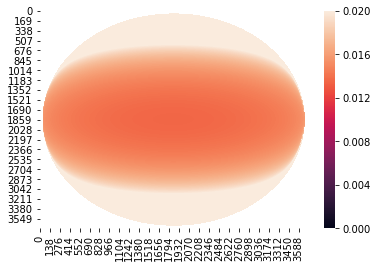

In [21]:
sns.heatmap(d_theta_new2, vmin = 0, vmax = 0.02)

In [82]:
def compute_area_one_cell(lat = 60, lon = -15, c_lat = None, 
                          c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    era_AREA = area_grid_cell(lat, 0.375, 0.375)
    print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))

    # Make this a loop over lat_lons?
    lat_bondaries = np.array([[lon],
                              [lat]])

    BOUND =  np.array([[-0.75/2, 0.75/2],
                       [-0.75/2, 0.75/2]])

    ranges = lat_bondaries + BOUND

    lon_range = ranges[0, :]
    lat_range = ranges[1, :]
    min_lon, max_lon = lon_range
    min_lat, max_lat = lat_range

    era_up    = ranges[1, 1]
    era_down  = ranges[1, 0]
    era_left  = ranges[0, 0]
    era_right = ranges[0, 1]

    cmk_left  = c_lon - np.abs(d_phi)   #- era_right
    cmk_right = c_lon + np.abs(d_phi)   #- era_left

    # TODO : Sjekk d theta og lignende.
    cmk_up    = c_lat + np.abs(d_theta) #- era_down
    cmk_down  = c_lat - np.abs(d_theta) #- era_up

    idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
    idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
    idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
    idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )
    
    lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
    lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
    upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
    upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

    corner_idx         = np.concatenate([lower_right_corner, lower_left_corner,
                                         upper_left_corner, upper_right_corner]) # corner idx



    
    #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
    
    # TODO add new centre corners. And calculate  
    llc_dlat = (era_down - cmk_up[lower_left_corner])/2
    llc_dlon = (era_left - cmk_right[lower_left_corner])/2
    llc_lat = era_down + llc_dlat
    f = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
    print("area lower left area {}".format(f))
    
    lrc_dlat = (era_down - cmk_up[lower_right_corner])/2
    lrc_dlon = (era_right - cmk_left[lower_right_corner])/2
    lrc_lat  = era_down + llc_dlat
    h = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
    print("area lower right area {}".format(h))
    
    ulc_dlat = (era_up - cmk_down[upper_left_corner])/2
    ulc_dlon = (era_left - cmk_right[upper_left_corner])/2
    ulc_lat = era_up - ulc_dlat
    i = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
    print("area upper left area {}".format(i))
    
    urc_dlat = (era_up - cmk_down[upper_right_corner])/2
    urc_dlon = (era_right - cmk_left[upper_right_corner])/2
    urc_lat  = era_up - ulc_dlat
    j = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
    print("area upper right area {}".format(j))
    

    if len(corner_idx) == 0:
        raise ValueError('No corners found, something is wrong ... ')
    
    max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
    max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

    # removes corners
    for idx in corner_idx:
        idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

    #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
    #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

    #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
    #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]
    
    # subsection left boundary OLD
    low_bound = np.argwhere( cmk_down[idx_left_boundary] < era_up  )
    up_bound  = np.argwhere( cmk_up[idx_left_boundary] > era_down )
    sub_section_left = np.intersect1d(low_bound, up_bound)

    # subsection right boundary
    low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
    up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
    sub_section_right = np.intersect1d(low_bound, up_bound)

    # Subsection Down Boundary
    one = np.argwhere( c_lon[idx_down_boundary] > min_lon )
    two = np.argwhere( c_lon[idx_down_boundary] < max_lon)
    sub_section_down = np.intersect1d(one, two)

    # subsection up boundary
    one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
    two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
    sub_section_up = np.intersect1d(one, two)
    
    plt.scatter(cmk_left[corner_idx],        cmk_up[corner_idx], marker = 'v')
    plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
    plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
    plt.scatter(cmk_left[idx_up_boundary][sub_section_up], cmk_up[idx_up_boundary][sub_section_up])
    plt.scatter(cmk_left[idx_down_boundary][sub_section_down], cmk_up[idx_down_boundary][sub_section_down])
    #plt.show()
    
    
    # test that these are empty
    t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
    t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
    #assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

    # Calculate Boundaries

    # AREA left boundary
    dlon_lf = np.abs(cmk_right[idx_left_boundary][sub_section_left] - era_left)/2 # negative values
    dlat_lf = d_theta[idx_left_boundary][sub_section_left]
    lat_lf  = c_lat[idx_left_boundary][sub_section_left]
    #lon_lf  = c_lon[idx_left_boundary][sub_section_left]

    a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

    fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                          dlat_lf,
                                                                                          dlon_lf)/era_AREA).sum()
    # AREA right boundary
    dlon_rb = np.abs((era_right - cmk_left[idx_right_boundary][sub_section_right])/2)
    dlat_rb = d_theta[idx_right_boundary][sub_section_right]
    lat_rb = c_lat[idx_right_boundary][sub_section_right]
    #lon_rb = c_lon[idx_right_boundary][sub_section_right]

    b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

    fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                          dlat_rb,
                                                                                          dlon_rb)/era_AREA).sum()

    # AREA down boundary
    dlat_down = np.abs((era_down - cmk_up[idx_down_boundary][sub_section_down]))/2
    lat_down = era_down + dlat_down
    dlon_down = d_phi[idx_down_boundary][sub_section_down]
    #lon_down =  c_lon[idx_down_boundary][sub_section_down]

    c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

    fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                          dlat_down,
                                                                                          dlon_down)/era_AREA).sum()
    # AREA up
    dlat_up = np.abs(cmk_down[idx_up_boundary][sub_section_up] - era_up)/2

    lat_up = era_up - dlat_up
    #lon_up = c_lon[idx_up_boundary][sub_section_up]
    dlon_up = d_phi[idx_up_boundary][sub_section_up]

    d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

    fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                 dlat_up,
                                                                 dlon_up)/era_AREA).sum()
    # Index centres.
    idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                    np.argwhere(cmk_right < era_right))


    idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                    np.argwhere(cmk_down >  era_down))

    idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
    lat_centre_cells = c_lat[idx_centre_cells]
    dlat_centre      = d_theta[idx_centre_cells]
    dlon_centre      = d_phi[idx_centre_cells]
    
    plt.scatter(c_lon[idx_centre_cells], lat_centre_cells)
    plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
    plt.show()
    
    fraction_centre  = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                 dlat_centre,
                                                                 dlon_centre)/era_AREA).sum()
    print("era_AREA {}".format(era_AREA))
    print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
    print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
    print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
    print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
    print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))
    
    Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                   area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                   area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA
    
    print("SUM weight {}".format(Test_weight))
    return


lat = 945.3930343633116, lon =30 era_AREA -15


/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/

area lower left area [0.5810764]
area lower right area [0.86590628]
area upper left area [1.18697162]
area upper right area [0.27826687]


/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in le

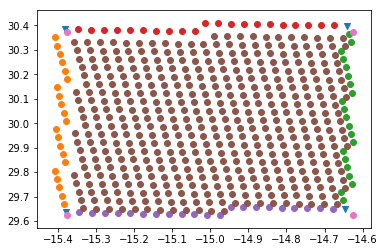

era_AREA 945.3930343633116
Sum up 0.020717908553291198
Sum down 0.019665120756522363
Sum centre 0.9197326645030672
Sum left 0.020695101219706143
Sum right 0.020924410313183303
SUM weight 1.0017352053457702
lat = 945.3930343633116, lon =30 era_AREA -5
area lower left area [1.02452732]
area lower right area [0.9741631]
area upper left area [0.10317063]
area upper right area [0.0743388]


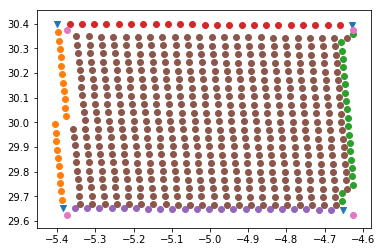

era_AREA 945.3930343633116
Sum up 0.01612967402210034
Sum down 0.031121963475195108
Sum centre 0.9110630348474831
Sum left 0.01932234623614743
Sum right 0.02059201527691851
SUM weight 0.9982290338578444
lat = 945.3930343633116, lon =30 era_AREA 5
area lower left area [0.97413093]
area lower right area [1.02449348]
area upper left area [0.07434152]
area upper right area [0.1031744]


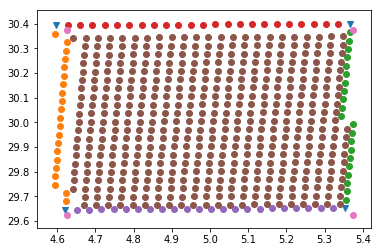

era_AREA 945.3930343633116
Sum up 0.016129674022100346
Sum down 0.03112196347519511
Sum centre 0.9110630348474831
Sum left 0.02059201527691851
Sum right 0.01932234623614743
SUM weight 0.9982290338578444
lat = 945.3930343633116, lon =30 era_AREA 15
area lower left area [0.86596812]
area lower right area [0.5811179]
area upper left area [0.2782467]
area upper right area [1.18688555]


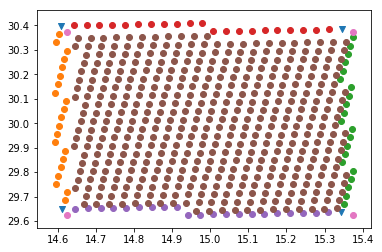

era_AREA 945.3930343633116
Sum up 0.020717908553291198
Sum down 0.019665120756522367
Sum centre 0.9197326645030673
Sum left 0.020924410313183303
Sum right 0.020695101219706143
SUM weight 1.0017352053457702
lat = 945.3930343633116, lon =30 era_AREA 25
area lower left area [1.03364799]
area lower right area [1.26079962]
area upper left area [0.2580161]
area upper right area [0.15123903]


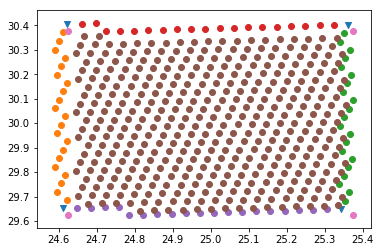

era_AREA 945.3930343633116
Sum up 0.02458306528840704
Sum down 0.019211609509609866
Sum centre 0.9189717194460307
Sum left 0.022736469292407732
Sum right 0.02521645511418273
SUM weight 1.0107193186506382
lat = 945.3930343633116, lon =30 era_AREA 35
area lower left area [0.02564861]
area lower right area [0.06232545]
area upper left area [1.61009341]
area upper right area [0.68971391]


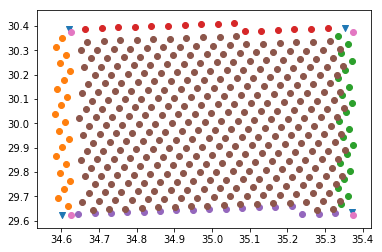

era_AREA 945.3930343633116
Sum up 0.02141013396108688
Sum down 0.02160850426602807
Sum centre 0.9243694717356229
Sum left 0.028822725061002665
Sum right 0.02889958882646732
SUM weight 1.0251104238502078
lat = 894.223926193326, lon =35 era_AREA -15
area lower left area [0.16484202]
area lower right area [0.01734268]
area upper left area [1.21030656]
area upper right area [0.37834221]


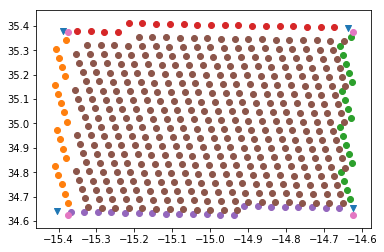

era_AREA 894.223926193326
Sum up 0.018766379622401765
Sum down 0.022288031642706888
Sum centre 0.9186360161876234
Sum left 0.023170655444452872
Sum right 0.021893490342036876
SUM weight 1.0047545732392218
lat = 894.223926193326, lon =35 era_AREA -5
area lower left area [0.47936684]
area lower right area [0.44713595]
area upper left area [1.20922788]
area upper right area [0.0958934]


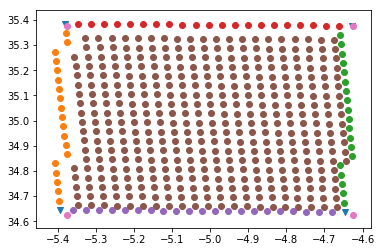

era_AREA 894.223926193326
Sum up 0.0402762514065449
Sum down 0.020931303852298376
Sum centre 0.8910239717301103
Sum left 0.01995295278152368
Sum right 0.02604632411822843
SUM weight 0.9982308038887058
lat = 894.223926193326, lon =35 era_AREA 5
area lower left area [0.44711487]
area lower right area [0.47934424]
area upper left area [0.09589816]
area upper right area [1.20928789]


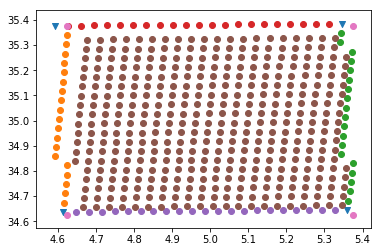

era_AREA 894.223926193326
Sum up 0.0402762514065449
Sum down 0.020931303852298373
Sum centre 0.8910239717301103
Sum left 0.02604632411822843
Sum right 0.01995295278152368
SUM weight 0.9982308038887058
lat = 894.223926193326, lon =35 era_AREA 15
area lower left area [0.01734403]
area lower right area [0.16485484]
area upper left area [0.37830974]
area upper right area [1.2102027]


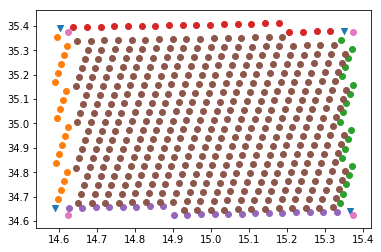

era_AREA 894.223926193326
Sum up 0.018766379622401765
Sum down 0.022288031642706888
Sum centre 0.9186360161876232
Sum left 0.021893490342036876
Sum right 0.023170655444452872
SUM weight 1.0047545732392218
lat = 894.223926193326, lon =35 era_AREA 25
area lower left area [0.89397894]
area lower right area [0.41465708]
area upper left area [1.62677647]
area upper right area [0.31379387]


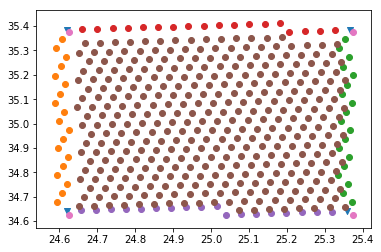

era_AREA 894.223926193326
Sum up 0.023272742082993104
Sum down 0.02323262769815342
Sum centre 0.9173190806458934
Sum left 0.02617226723513373
Sum right 0.025287449305113657
SUM weight 1.0152841669672874
lat = 894.223926193326, lon =35 era_AREA 35
area lower left area [0.81043842]
area lower right area [0.08012075]
area upper left area [1.24713141]
area upper right area [0.30044954]


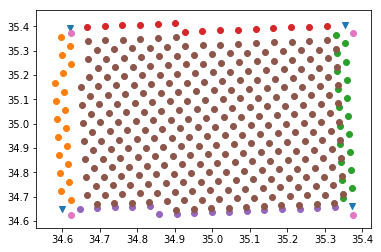

era_AREA 894.223926193326
Sum up 0.022329213408482238
Sum down 0.028606652140008404
Sum centre 0.9192732131860711
Sum left 0.03239996176355826
Sum right 0.03313835676299368
SUM weight 1.0357473972611138
lat = 836.2492339978413, lon =40 era_AREA -15
area lower left area [1.70408598]
area lower right area [0.11999234]
area upper left area [1.41123824]
area upper right area [0.25441154]


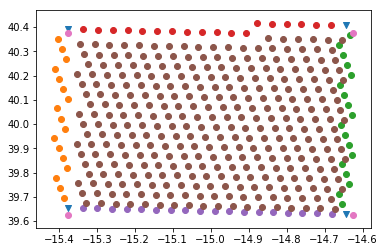

era_AREA 836.2492339978413
Sum up 0.029593799477728916
Sum down 0.0211220285883925
Sum centre 0.9029112777819862
Sum left 0.024466844159760956
Sum right 0.02669929802981249
SUM weight 1.004793248037681
lat = 836.2492339978413, lon =40 era_AREA -5
area lower left area [1.65837575]
area lower right area [0.68001178]
area upper left area [0.20269017]
area upper right area [0.11887853]


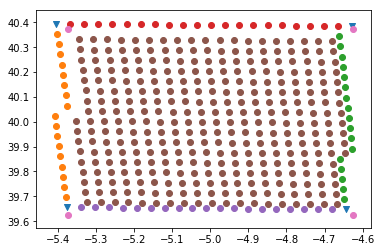

era_AREA 836.2492339978413
Sum up 0.03487165670523875
Sum down 0.03405993624657291
Sum centre 0.8773854745132659
Sum left 0.024432416577839126
Sum right 0.027039201252264507
SUM weight 0.9977886852951813
lat = 836.2492339978413, lon =40 era_AREA 5
area lower left area [0.67996934]
area lower right area [1.65827224]
area upper left area [0.11888676]
area upper right area [0.20270419]


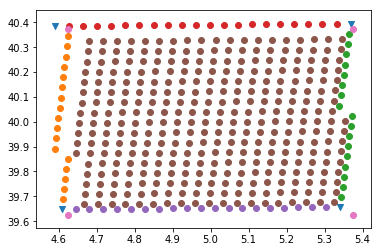

era_AREA 836.2492339978413
Sum up 0.034871656705238764
Sum down 0.03405993624657291
Sum centre 0.8773854745132659
Sum left 0.027039201252264507
Sum right 0.024432416577839126
SUM weight 0.9977886852951813
lat = 836.2492339978413, lon =40 era_AREA 15
area lower left area [0.11997037]
area lower right area [1.70377399]
area upper left area [0.25438211]
area upper right area [1.41107499]


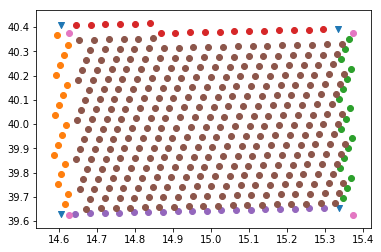

era_AREA 836.2492339978413
Sum up 0.029593799477728916
Sum down 0.0211220285883925
Sum centre 0.9029112777819863
Sum left 0.02669929802981249
Sum right 0.024466844159760956
SUM weight 1.004793248037681
lat = 836.2492339978413, lon =40 era_AREA 25
area lower left area [0.01318713]
area lower right area [0.06278182]
area upper left area [0.37521447]
area upper right area [0.19150081]


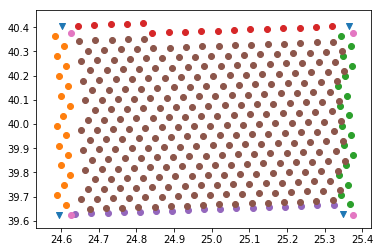

era_AREA 836.2492339978413
Sum up 0.027544648618590947
Sum down 0.02846747543281957
Sum centre 0.9114731790009379
Sum left 0.030051519723832052
Sum right 0.027167534777155083
SUM weight 1.0247043575533357
lat = 836.2492339978413, lon =40 era_AREA 35
area lower left area [0.79254283]
area lower right area [2.59854609]
area upper left area [1.63242421]
area upper right area [0.61830562]


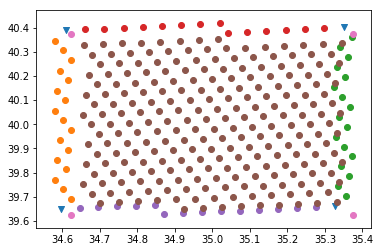

era_AREA 836.2492339978413
Sum up 0.026294027622022202
Sum down 0.030552396192862402
Sum centre 0.9188909231464442
Sum left 0.03629668257599592
Sum right 0.033113436792573524
SUM weight 1.045147466329898
lat = 771.9101801905401, lon =45 era_AREA -15
area lower left area [1.09850418]
area lower right area [0.21892878]
area upper left area [1.34751679]
area upper right area [0.33176408]


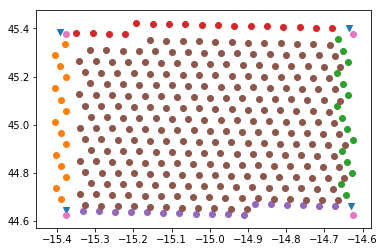

era_AREA 771.9101801905401
Sum up 0.02309010009728289
Sum down 0.026182725812377565
Sum centre 0.8962385425488156
Sum left 0.034128633097498993
Sum right 0.028357557325695115
SUM weight 1.00799755888167
lat = 771.9101801905401, lon =45 era_AREA -5
area lower left area [0.64578427]
area lower right area [0.2321465]
area upper left area [0.94338441]
area upper right area [2.1557703]


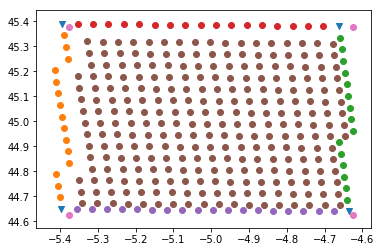

era_AREA 771.9101801905401
Sum up 0.04465391736123743
Sum down 0.025525508407266684
Sum centre 0.8754105676511844
Sum left 0.02531806290218342
Sum right 0.02521718529917089
SUM weight 0.9961252416210427
lat = 771.9101801905401, lon =45 era_AREA 5
area lower left area [0.23212655]
area lower right area [0.64572875]
area upper left area [2.15595581]
area upper right area [0.94346559]


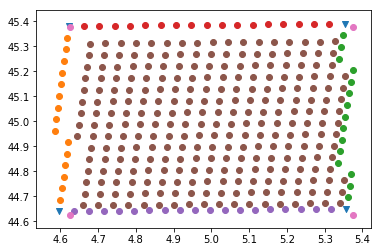

era_AREA 771.9101801905401
Sum up 0.04465391736123742
Sum down 0.025525508407266684
Sum centre 0.8754105676511842
Sum left 0.02521718529917089
Sum right 0.02531806290218342
SUM weight 0.9961252416210425
lat = 771.9101801905401, lon =45 era_AREA 15
area lower left area [0.21896094]
area lower right area [1.09866555]
area upper left area [0.3317139]
area upper right area [1.34731296]


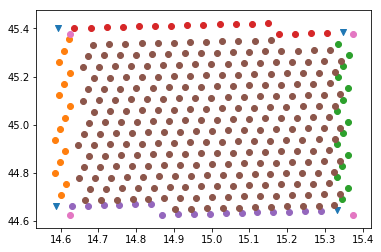

era_AREA 771.9101801905401
Sum up 0.023090100097282896
Sum down 0.02618272581237756
Sum centre 0.8962385425488154
Sum left 0.028357557325695115
Sum right 0.034128633097498993
SUM weight 1.0079975588816699
lat = 771.9101801905401, lon =45 era_AREA 25
area lower left area [1.52008861]
area lower right area [1.11871272]
area upper left area [0.42220129]
area upper right area [0.12174694]


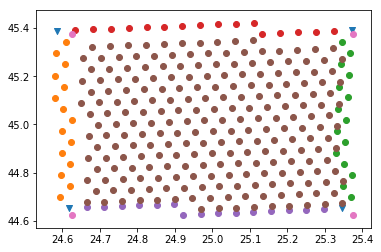

era_AREA 771.9101801905401
Sum up 0.03356745351923297
Sum down 0.028728519900213977
Sum centre 0.9057276347382123
Sum left 0.03123457858155557
Sum right 0.03022282986706565
SUM weight 1.0294810166062804
lat = 771.9101801905401, lon =45 era_AREA 35
area lower left area [0.03965124 0.14586501]
area lower right area [0.92378589 0.92413645]
area upper left area [0.21089377]
area upper right area [1.90145562 0.2634642 ]


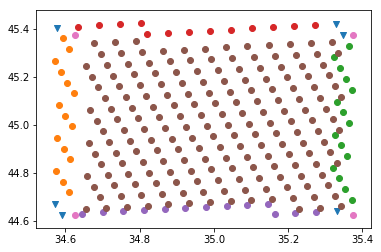

era_AREA 771.9101801905401
Sum up 0.02790405883793836
Sum down 0.027762070535713137
Sum centre 0.9366451554557629
Sum left 0.03632293985946794
Sum right 0.036622458024338465
SUM weight 1.0652566827132208
lat = 701.6964238198714, lon =50 era_AREA -15
area lower left area [0.31528024]
area lower right area [1.74347083]
area upper left area [1.94237372]
area upper right area [0.66946179]


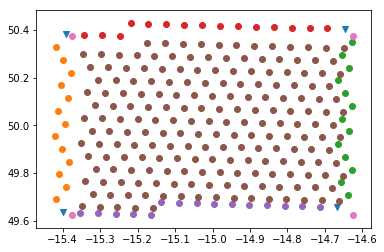

era_AREA 701.6964238198714
Sum up 0.026298909083428596
Sum down 0.03874833245019647
Sum centre 0.8924924603819402
Sum left 0.02625903068204724
Sum right 0.024968086591398476
SUM weight 1.008766819189011
lat = 701.6964238198714, lon =50 era_AREA -5
area lower left area [0.1118558]
area lower right area [0.93182213]
area upper left area [1.33975722]
area upper right area [1.17075709]


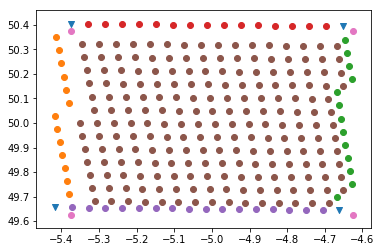

era_AREA 701.6964238198714
Sum up 0.03536140131927259
Sum down 0.03275830728678199
Sum centre 0.8747426838840399
Sum left 0.02742949061047732
Sum right 0.02633217756672684
SUM weight 0.9966240606672986
lat = 701.6964238198714, lon =50 era_AREA 5
area lower left area [0.93171719]
area lower right area [0.11184321]
area upper left area [1.17088747]
area upper right area [1.33990642]


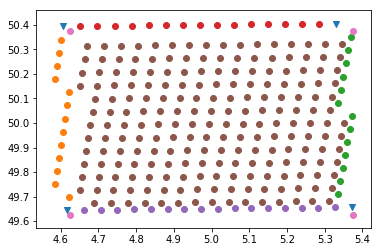

era_AREA 701.6964238198714
Sum up 0.03536140131927259
Sum down 0.03275830728678199
Sum centre 0.8747426838840399
Sum left 0.02633217756672684
Sum right 0.02742949061047732
SUM weight 0.9966240606672986
lat = 701.6964238198714, lon =50 era_AREA 15
area lower left area [1.7438576]
area lower right area [0.31535018]
area upper left area [0.66930696]
area upper right area [1.94192449]


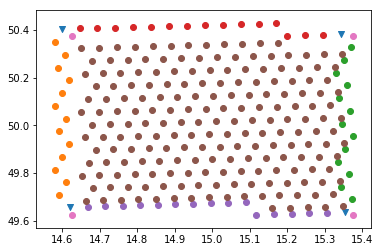

era_AREA 701.6964238198714
Sum up 0.026298909083428593
Sum down 0.038748332450196474
Sum centre 0.89249246038194
Sum left 0.024968086591398476
Sum right 0.02625903068204724
SUM weight 1.0087668191890107
lat = 701.6964238198714, lon =50 era_AREA 25
area lower left area [1.15561357]
area lower right area [1.73234248]
area upper left area [0.30714562]
area upper right area [0.40438815]


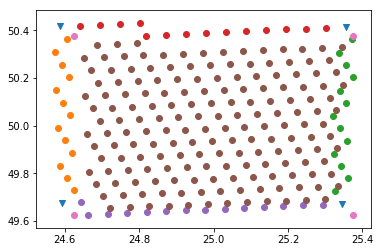

era_AREA 701.6964238198714
Sum up 0.0370011866780849
Sum down 0.03232318776080697
Sum centre 0.900249309756845
Sum left 0.03363923128948766
Sum right 0.03556918160385209
SUM weight 1.0387820970890767
lat = 701.6964238198714, lon =50 era_AREA 35
area lower left area [2.29708943]
area lower right area [0.00779827]
area upper left area [1.39745011]
area upper right area [0.0515841]


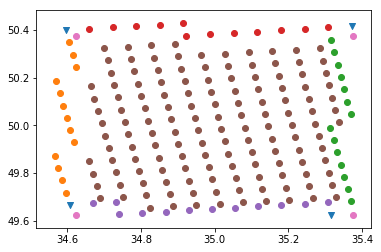

era_AREA 701.6964238198714
Sum up 0.039866613407905524
Sum down 0.040550168916368944
Sum centre 0.914316055946569
Sum left 0.04321240064267342
Sum right 0.047400714877851545
SUM weight 1.0853459537913683
lat = 626.1423339680531, lon =55 era_AREA -15
area lower left area [1.41359102]
area lower right area [0.16668693]
area upper left area [0.32922123]
area upper right area [1.16815707]


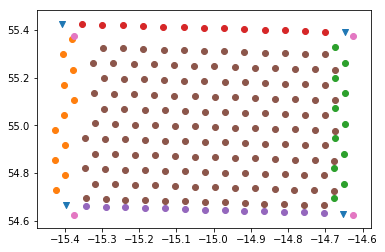

era_AREA 626.1423339680531
Sum up 0.039736010703102995
Sum down 0.02827289495965874
Sum centre 0.8650318904800502
Sum left 0.03487183180165543
Sum right 0.04744444778843808
SUM weight 1.0153570757329053
lat = 626.1423339680531, lon =55 era_AREA -5
area lower left area [1.51474529]
area lower right area [0.9060065]
area upper left area [0.88803688]
area upper right area [1.59626121]


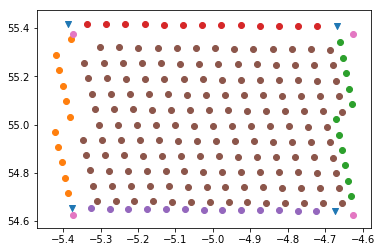

era_AREA 626.1423339680531
Sum up 0.03170595402932667
Sum down 0.02600874472187457
Sum centre 0.8765576219636978
Sum left 0.03145023149258717
Sum right 0.02868234795552647
SUM weight 0.9944049001630126
lat = 626.1423339680531, lon =55 era_AREA 5
area lower left area [0.9058819]
area lower right area [1.51453696]
area upper left area [1.59649403]
area upper right area [0.8881664]


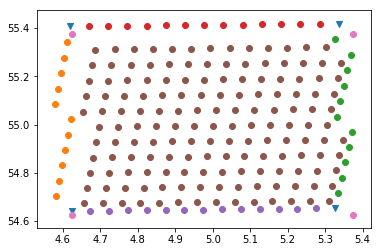

era_AREA 626.1423339680531
Sum up 0.03170595402932666
Sum down 0.02600874472187457
Sum centre 0.8765576219636978
Sum left 0.02868234795552647
Sum right 0.03145023149258717
SUM weight 0.9944049001630126
lat = 626.1423339680531, lon =55 era_AREA 15
area lower left area [0.16661594]
area lower right area [1.41298902]
area upper left area [1.16868459]
area upper right area [0.3293699]


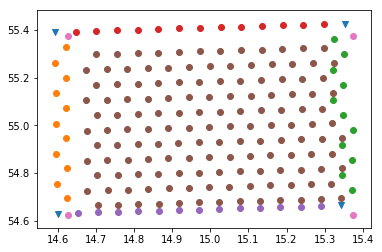

era_AREA 626.1423339680531
Sum up 0.039736010703102995
Sum down 0.02827289495965874
Sum centre 0.8650318904800502
Sum left 0.04744444778843808
Sum right 0.03487183180165543
SUM weight 1.0153570757329053
lat = 626.1423339680531, lon =55 era_AREA 25
area lower left area [2.34905502]
area lower right area [1.09468175]
area upper left area [0.56145404]
area upper right area [1.56481376]


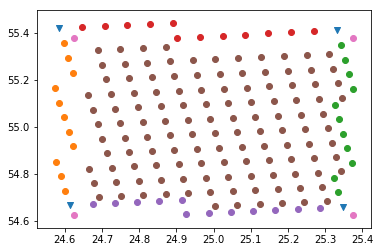

era_AREA 626.1423339680531
Sum up 0.04427272243431387
Sum down 0.04215191301217841
Sum centre 0.8842345993574622
Sum left 0.04343263990725674
Sum right 0.03460283601360571
SUM weight 1.0486947107248168
lat = 626.1423339680531, lon =55 era_AREA 35
area lower left area [2.04174261]
area lower right area [1.69230916]
area upper left area [1.71821918]
area upper right area [3.00485923]


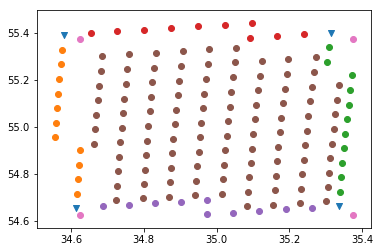

era_AREA 626.1423339680531
Sum up 0.04630998307263454
Sum down 0.043108394824369616
Sum centre 0.9331603637131026
Sum left 0.0443843451742712
Sum right 0.03990296314617645
SUM weight 1.1068660499305543


In [83]:
for la in [30, 35, 40, 45, 50, 55]:
    for lo in [-15, -5, 5, 15, 25, 35]:
        compute_area_one_cell(lat = la, lon = lo, c_lat = lat_array.reshape(-1), 
                              c_lon = lon_array.reshape(-1), d_theta = d_theta_new2.reshape(-1), 
                              d_phi = d_phi_new2.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1)  )


In [62]:
plt.scatter(c_lon[idx_up_boundary],   c_lat[idx_up_boundary])
plt.scatter(c_lon[idx_down_boundary], c_lat[idx_down_boundary])

NameError: name 'c_lon' is not defined

In [ ]:
plt.scatter(c_lon[idx_left_boundary], c_lat[idx_left_boundary])
plt.scatter(c_lon[idx_right_boundary], c_lat[idx_right_boundary])

In [ ]:
plt.scatter(c_lon[idx_down_boundary], c_lat[idx_down_boundary])

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_up[idx_left_boundary] > min_lat  )
up_bound  = np.argwhere( cmk_down[idx_left_boundary] < max_lat  )
sub_section_left = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_left

In [ ]:
#  subsection right boundary
low_bound = np.argwhere( cmk_up[idx_right_boundary] > min_lat )
up_bound  = np.argwhere( cmk_down[idx_right_boundary] < max_lat)
sub_section_right = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_right

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_up_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_up_boundary] < max_lon  )
sub_section_up = np.intersect1d(low_bound, up_bound)


In [ ]:
sub_section_up

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_down_boundary] < max_lon  )
sub_section_down = np.intersect1d(low_bound, up_bound)

In [ ]:
up_bound.flatten()

In [ ]:
low_bound.flatten()

In [ ]:
idx_up_boundary

In [ ]:
sub_section_left

In [ ]:
min_lon, max_lon, min_lat, max_lat

In [ ]:
sub_section_down, sub_section_up

In [ ]:
(c_lon[idx_down_boundary] > min_lon).sum()

In [ ]:
( c_lon[idx_down_boundary] < max_lon).sum()

In [ ]:
max_lon

In [ ]:
cmk_left[idx_down_boundary][one].flatten() < -14.

In [ ]:
# Subsection Down Boundary
one = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
two = np.argwhere( cmk_left[idx_down_boundary][one]  < max_lon )

sub_section_down = np.intersect1d(one, two)


In [ ]:
two

In [ ]:
cmk_right[idx_down_boundary][one]

In [ ]:
cmk_left[idx_down_boundary]

In [ ]:
one.flatten()

In [ ]:
two.flatten()

In [ ]:
cmk_left[idx_down_boundary] < max_lon)

In [ ]:
cmk_right[idx_down_boundary][cmk_right[idx_down_boundary] > min_lon] < ma

In [ ]:
sub_section_down

In [ ]:
plt.scatter(c_lon[sub_section_down][sub_section_down], c_lat[sub_section_down][sub_section_down] ) 

In [ ]:

# subsection up boundary
one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
sub_section_up = np.intersect1d(one, two)

In [ ]:
c_lon[idx_left_boundary][sub_section_left], c_lat[idx_left_boundary][sub_section_left]

In [ ]:
c_lon[idx_up_boundary]#[sub_section_up]


In [ ]:
plt.scatter(c_lon[idx_left_boundary][sub_section_left],    c_lat[idx_left_boundary][sub_section_left], label = 'left')
plt.scatter(c_lon[idx_right_boundary][sub_section_right],  c_lat[idx_right_boundary][sub_section_right], label = 'right')
plt.scatter(c_lon[idx_up_boundary][sub_section_up],        c_lat[idx_up_boundary][sub_section_up], label = 'up')
plt.scatter(c_lon[idx_down_boundary][sub_section_down],    c_lat[idx_down_boundary][sub_section_down], label = 'down')
plt.legend()
#plt.scatter([-15.375, 14.625, -15.375, 14.625], [30.375, 30.375, 29.625, 29.625])

In [ ]:
c_lat[idx_left_boundary], c_lon[idx_right_boundary]

In [ ]:
clm_ax = sns.heatmap(cloud_mask)
clm_ax.invert_yaxis()

# index 0,0 is at the lower left corner 

In [ ]:
clm_ax = sns.heatmap(np.flipud(cloud_mask))

In [ ]:
ax = sns.heatmap(lat_array)
ax.set_xlabel('longitude i')
ax.set_ylabel('latitude j')


In [ ]:
ax2 = sns.heatmap(lon_array) # longitude is incleasing with index but latitude is deacreasing.

In [ ]:
compute_area_one_cell(lat = 30, lon = -15, c_lat = lat_array.reshape(-1), 
                      c_lon = lon_array.reshape(-1), d_theta = d_theta.reshape(-1), 
                      d_phi = d_phi.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1))

In [ ]:
area_grid_cell(lat_up, dlat_up, dlon_up).sum()

In [ ]:
area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                  area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA

In [ ]:
lat_array

In [ ]:
sns.heatmap(d_phi)

In [ ]:
sns.heatmap(d_theta)

In [ ]:
coord_info = pd.read_csv('~/Desktop/lat_lon_dlat_dlon.csv')
c_lat = coord_info.lat.values
c_lon = coord_info.lon.values
d_phi_new = coord_info.dlon.values
d_theta_new = coord_info.dlat.values

In [ ]:
d_theta_new.shape

In [ ]:
np.sqrt(10375000)

In [ ]:
sns.heatmap(d_phi.reshape((3712,3712)) )

In [ ]:
sns.heatmap(d_theta.reshape((3712,3712)) )

In [ ]:
#plt.scatter(c_lat.)

In [ ]:
#c_lon[c_lon < -99] = np.nan
#c_lat[c_lat < -99] = np.nan

In [ ]:
#sns.kdeplot(c_lon, c_lat)

In [ ]:
#sns.heatmap(d_phi.reshape((3712, 3712)))

In [ ]:
#sns.heatmap(d_theta.reshape((3712, 3712)))